In this notebook, I tried to learn about Batch Normalization from this paper http://arxiv.org/abs/1502.03167 and implement it using tensorflow.

The dataset used is widely known MNIST dataset. I implemented 2 model, the first one is Artificial Neural Network and the second one is Convolutional Neural Network. Both of the network will be implemented with and without batch normalization so we can compare the result.

Based from the result from this notebook, I can conclude that using Batch Normalization can increase the training speed without reducing the accuracy.

In [1]:
import sys
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
%matplotlib inline
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# Model 1
## Implementing Batch Normalization to Multi Layer Perceptron 

The following code is basically the same with http://r2rt.com/implementing-batch-normalization-in-tensorflow.html

In [2]:
# initializer for weight in 3 layers of multi layer perceptron
w1_initial = np.random.normal(size=(784, 100)).astype(np.float32)
w2_initial = np.random.normal(size=(100, 100)).astype(np.float32)
w3_initial = np.random.normal(size=(100, 10)).astype(np.float32)

epsilon = 1e-3

In [3]:
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

#### Normal Multi Layer Perceptron

In [4]:
## First Dense layer
w1 = tf.Variable(w1_initial)
b1 = tf.Variable(tf.zeros([100]))
z1 = tf.matmul(x, w1) + b1
l1 = tf.nn.sigmoid(z1)

## Second Dense layer
w2 = tf.Variable(w2_initial)
b2 = tf.Variable(tf.zeros([100]))
z2 = tf.matmul(l1,w2)+b2
l2 = tf.nn.sigmoid(z2)

## Readout layer
w3 = tf.Variable(w3_initial)
b3 = tf.Variable(tf.zeros([10]))
z3 = tf.matmul(l2,w3)+b3
y  = tf.nn.softmax(z3)

# Train & metrics
cross_entropy = -tf.reduce_sum(y_*tf.log(y))
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)
correct_prediction = tf.equal(tf.arg_max(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#### Multi Layer Perceptron with Batch Normalization

In [5]:
## First Dense layer
w1_BN = tf.Variable(w1_initial)
z1_BN = tf.matmul(x,w1_BN)
# Introduce mean and var
batch_mean1, batch_var1 = tf.nn.moments(z1_BN, [0])
z1_hat = (z1_BN - batch_mean1) / tf.sqrt(batch_var1 + epsilon)
# Introduce new tensor variable to learn the distribution
scale1 = tf.Variable(tf.ones([100]))
beta1 = tf.Variable(tf.zeros([100]))
BN1 = scale1 * z1_hat + beta1
l1_BN = tf.nn.sigmoid(BN1)

## Second Dense Layer
w2_BN = tf.Variable(w2_initial)
z2_BN = tf.matmul(l1_BN,w2_BN)
# Introduce mean and var
batch_mean2, batch_var2 = tf.nn.moments(z2_BN,[0])
# Use variable to learn the distribution
scale2 = tf.Variable(tf.ones([100]))
beta2 = tf.Variable(tf.zeros([100]))
# Use the tensorflow batch_normalization function
BN2 = tf.nn.batch_normalization(z2_BN,batch_mean2,batch_var2,beta2,scale2,epsilon)
l2_BN = tf.nn.sigmoid(BN2)

## Readout Layer
w3_BN = tf.Variable(w3_initial)
b3_BN = tf.Variable(tf.zeros([10]))
y_BN  = tf.nn.softmax(tf.matmul(l2_BN,w3_BN)+b3_BN)

# Train & metrics
cross_entropy_BN = -tf.reduce_sum(y_*tf.log(y_BN))
train_step_BN = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy_BN)
correct_prediction_BN = tf.equal(tf.arg_max(y_BN, 1), tf.arg_max(y_, 1))
accuracy_BN = tf.reduce_mean(tf.cast(correct_prediction_BN, tf.float32))

##### Training both of the models

In [6]:
zs, BNs, acc, acc_BN = list(), list(), list(), list()

sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())
for i in range(40000):
    batch_x, batch_y = mnist.train.next_batch(60)
    feed = {x:batch_x, y_:batch_y}
    train_step.run(feed_dict=feed)
    train_step_BN.run(feed_dict=feed)
    if i % 50 == 0:
        acc_, acc_BN_, zs_, BNs_ = sess.run([accuracy,
            accuracy_BN, z3, BN2], feed_dict={x:mnist.test.images,
            y_: mnist.test.labels})
        acc.append(acc_)
        acc_BN.append(acc_BN_)
        zs.append(np.mean(zs_, axis=0))
        BNs.append(np.mean(BNs_, axis=0))
    print("\rTraining Step-%d"%(i+1), end="")
zs, BNs, acc, acc_BN = (np.array(x) for x in [zs, BNs, acc, acc_BN])

Training Step-40000

##### Comparing the result from both models

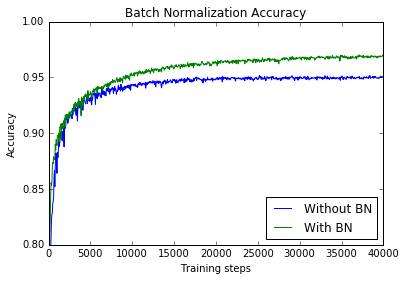

In [7]:
fig, ax = plt.subplots()

ax.plot(range(0, len(acc)*50, 50), acc, label='Without BN')
ax.plot(range(0, len(acc)*50, 50), acc_BN, label='With BN')
ax.set_xlabel('Training steps')
ax.set_ylabel('Accuracy')
ax.set_ylim([0.8, 1])
ax.set_title('Batch Normalization Accuracy')
ax.legend(loc=4)
plt.show()

In [9]:
predictions=list()
correct=0
for i in range(100):
    pred= sess.run(tf.arg_max(y_BN, 1),
        feed_dict={x:[mnist.test.images[i]],y_:[mnist.test.labels[i]]})
    predictions.append(pred[0])

print("Predictions:", predictions)

Predictions: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [10]:
sess.close()

## Problem !!!

From the cell above we know that it actually train well but predicting the same number at the the test time.

## Solution
From the r2rt blog we actually need to change the mean and the var when testing into the whole population mean and var.

However, I found out that there is a new framework from tensorflow to implement this using tf.contrib.layers.batch_norm. So, I'm gonna use it

In [11]:
def build_graph_with_bn():
    x = tf.placeholder(tf.float32, shape=[None, 784], name="x")
    y_ = tf.placeholder(tf.float32, shape=[None, 10], name="y_")
    is_train = tf.placeholder(tf.bool)

    with tf.name_scope('layer1') as scope:
        w = tf.Variable(w1_initial)
        z = tf.matmul(x,w)
        BN = tf.contrib.layers.batch_norm(z, is_training=is_train,
            updates_collections=None)
        l = tf.nn.sigmoid(z)

    with tf.name_scope('layer2') as scope:
        w = tf.Variable(w2_initial)
        z = tf.matmul(l,w)
        BN = tf.contrib.layers.batch_norm(z, is_training=is_train,
            updates_collections=None)
        l = tf.nn.sigmoid(z)
        
    with tf.name_scope('softmax') as scope:
        w = tf.Variable(w3_initial)
        b = tf.Variable(tf.constant(0.1, shape=[10]))
        y  = tf.nn.softmax(tf.matmul(l,w)+b)

    cross_entropy = -tf.reduce_sum(y_*tf.log(y))
    train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)
    correct_prediction = tf.equal(tf.arg_max(y, 1), tf.arg_max(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    return (x,y_,is_train), train_step, accuracy, y, tf.train.Saver()

In [12]:
(x, y_,is_train), train_step, accuracy, y, saver = build_graph_with_bn()

acc_BN2 = []
predictions=list()
correct=0

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    for i in range (10000):
        batch_x, batch_y = mnist.train.next_batch(60)
        sess.run(train_step, feed_dict={x:batch_x, y_:batch_y,
                                        is_train:True})
        if i % 50 == 0:
            res = sess.run(accuracy, feed_dict={x:mnist.test.images,
                y_:mnist.test.labels, is_train:False})
            acc_BN2.append(res)
            print(".", end="")
    for i in range(100):
        pred, corr = sess.run([tf.arg_max(y, 1), accuracy],
            feed_dict={x:[mnist.test.images[i]],y_:[mnist.test.labels[i]],
            is_train:False})
        correct+= corr
        predictions.append(pred[0])

print("\n\nFinal accuracy:", acc_BN2[-1])
print("Predictions:", predictions)
print("Accuracy:", correct/100)


........................................................................................................................................................................................................

Final accuracy: 0.943
Predictions: [7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 6, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 3, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 2, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9]
Accuracy: 0.96


## Fixed
As you can see, the prediction at the runtime have been fixed

# Model2
## Batch Normalization in Convolution Neural Network


The network used in this model is similar to the tutorial of the tensorflow [https://www.tensorflow.org/versions/r0.10/tutorials/mnist/pros/index.html#deep-mnist-for-experts] with an addition of batch normalization added to the convolution layer and the dense layer. The difference is this code uses tensorflow contrib library to provide cleaner code.

In [13]:
def build_cnn(x, y_, is_train, with_bn=True):
    x_2d = tf.reshape(x, [-1, 28, 28, 1])
    
    #Setup normalization parameters
    if with_bn:
        normalizer_fn = tf.contrib.layers.batch_norm
        normalizer_params = {"is_training":is_train, "updates_collections":None}
    else:
        normalizer_fn, normalizer_params = None, None

    #Build the network
    with tf.variable_scope('conv1'):
        conv1 = tf.contrib.layers.convolution2d(x_2d, kernel_size=[5,5],
                    num_outputs = 32, stride=[1,1], padding='SAME',
                    normalizer_fn = normalizer_fn,
                    weights_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        pool1 = tf.contrib.layers.max_pool2d(conv1, kernel_size=[2,2],
                    stride=[2,2], padding='SAME')
        print("Conv1", pool1.get_shape())
    
    with tf.variable_scope('conv2'):
        conv2 = tf.contrib.layers.convolution2d(pool1, kernel_size=[5,5],
                    num_outputs = 64, stride=[1,1], padding='SAME',
                    normalizer_fn = normalizer_fn,
                    weights_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        pool2 = tf.contrib.layers.max_pool2d(conv2, kernel_size=[2,2],
                    stride=[2,2], padding='SAME')
        print("Conv2", pool2.get_shape())
        
    with tf.variable_scope('flatten'):
        flatten = tf.contrib.layers.flatten(pool2)
        print("Flatten", flatten.get_shape())
    
    with tf.variable_scope('dense'):
        dense = tf.contrib.layers.fully_connected(flatten, 1024,normalizer_fn = normalizer_fn)
        print("Dense", dense.get_shape())
        
    with tf.variable_scope('dropout'):
        train_keep_prob = tf.constant(0.5)
        test_keep_prob = tf.constant(1.0)
        drop = tf.nn.dropout(dense, tf.select(
                is_train, train_keep_prob, test_keep_prob))
        print("Dropout", drop.get_shape())
        
    with tf.variable_scope('readout'):
        y = tf.contrib.layers.fully_connected(drop, 10, tf.nn.softmax)
        print("Readout", y.get_shape())

    cross_entropy = -tf.reduce_sum(y_*tf.log(y))
    train_step = tf.train.AdamOptimizer(1e-4).minimize(
        cross_entropy)
    correct_prediction = tf.equal(tf.arg_max(y, 1), tf.arg_max(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    return train_step, accuracy, y


Building Convolutional Neural Net without Batch normalization
Conv1 (?, 14, 14, 32)
Conv2 (?, 7, 7, 64)
Flatten (?, 3136)
Dense (?, 1024)
Dropout (?, 1024)
Readout (?, 10)

Building Convolutional Neural Net with Batch normalization
Conv1 (?, 14, 14, 32)
Conv2 (?, 7, 7, 64)
Flatten (?, 3136)
Dense (?, 1024)
Dropout (?, 1024)
Readout (?, 10)

Training.. #5000/5000


Final accuracy without BN 0.9892
Final accuracy with BN 0.9926


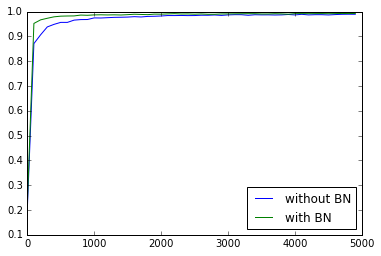

In [15]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=[None, 784], name="x")
y_ = tf.placeholder(tf.float32, shape=[None, 10], name="y_")
is_train = tf.placeholder(tf.bool)

with tf.variable_scope('cnn') as scope:
    print("\nBuilding Convolutional Neural Net without Batch normalization")
    train_step, accuracy, y = build_cnn(x, y_, is_train, with_bn=False)

with tf.variable_scope('cnn_bn') as scope:
    print("\nBuilding Convolutional Neural Net with Batch normalization")
    train_stepBN, accuracyBN, yBN = build_cnn(x, y_, is_train, with_bn=True)

print()

train_iter = 5000
acc_CNN = []
acc_CNN_BN = []

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    for i in range (train_iter):
        batch_x, batch_y = mnist.train.next_batch(50)
        sess.run([train_step, train_stepBN], feed_dict={x:batch_x, y_:batch_y,
                                        is_train:True})
        if i % 100 == 0:
            res_CNN, res_CNN_BN = sess.run([accuracy, accuracyBN], 
                                feed_dict={x:mnist.test.images,
                                y_:mnist.test.labels, is_train:False})
            acc_CNN.append(res_CNN)
            acc_CNN_BN.append(res_CNN_BN)
        print("\rTraining.. #%d/%d" % (i+1, train_iter), end="")

print("\n\n")
print("Final accuracy without BN", acc_CNN[-1])
print("Final accuracy with BN", acc_CNN_BN[-1])
        
plt.plot(range(0, len(acc_CNN)*100, 100), acc_CNN, label='without BN')
plt.plot(range(0, len(acc_CNN)*100, 100), acc_CNN_BN, label='with BN')
ax.set_xlabel('Training steps')
ax.set_ylabel('Accuracy')
ax.set_ylim([0.8, 1])
plt.legend(loc=4)
plt.show()